<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep5-eda-modeling?scriptVersionId=118073970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Wine Quality Prediction</h1>

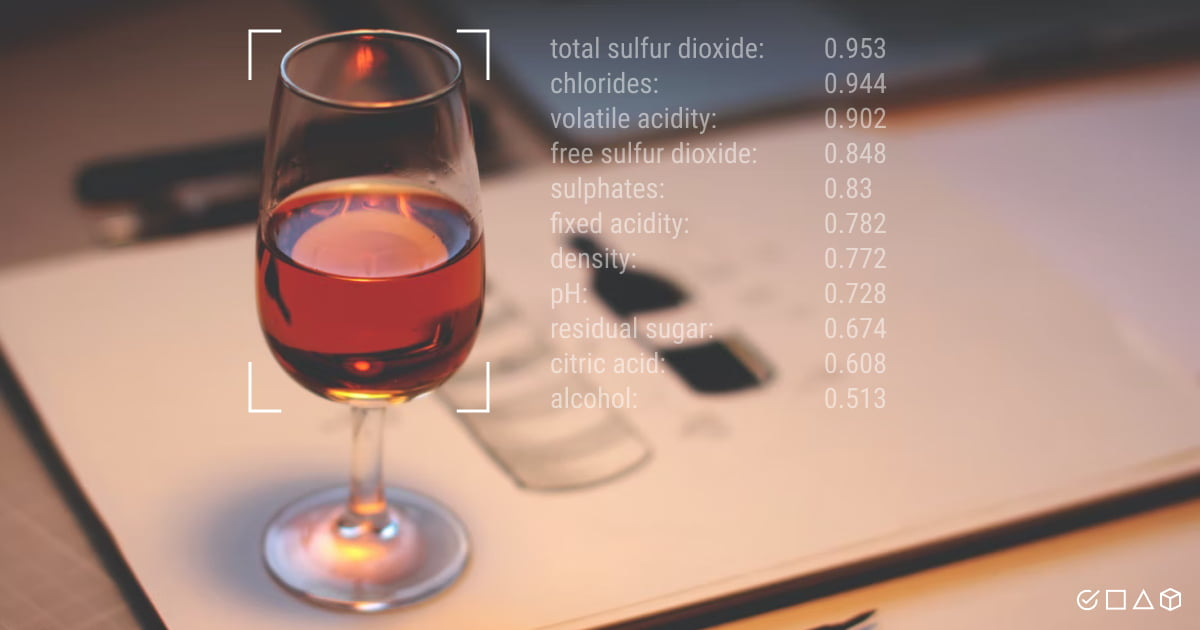

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#Notebook-Versions)

[2. Loading Libraries](#Loading-Libraries)

[3. Reading Data Files](#Reading-Data-Files)

[4. Data Exploration](#Data-Exploration)

[5. OneVsRest Overview](#OneVsRest-Overview)

[6 OneVsRest XGBoost](#OneVsRest:-XGBoost)

[7. XGBoost](#XGBoost)

[8. Feature Engineering](#Feature-Engineering)

[9. Model Comparison](#Model-Comparison)



<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (01/30/2023)
    * EDA 
    * OneVsRest with XGBoost

2. Version 2 (01/30/2023)
    * Fixing bug

3. Version 3 (01/30/2023)
    * Adding section labels

4. Version 4 (01/30/2023)
    * Fixing bug

5. Version 5 (02/01/2023)
    * XGBoost modeling added
    * Feature engineering added

6. Version 6 (02/02/2023)
    * Reducing the number of features in feature engineering
    * Model comparison added

7. Version 7 (02/02/2023)
    * XGBoost hyperparamters updated
    
<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e5/train.csv')
test = pd.read_csv('../input/playground-series-s3e5/test.csv')
submission = pd.read_csv('../input/playground-series-s3e5/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (2056, 13)
The dimession of the test dataset is: (1372, 12)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    2056 non-null   int64  
 1   fixed acidity         2056 non-null   float64
 2   volatile acidity      2056 non-null   float64
 3   citric acid           2056 non-null   float64
 4   residual sugar        2056 non-null   float64
 5   chlorides             2056 non-null   float64
 6   free sulfur dioxide   2056 non-null   float64
 7   total sulfur dioxide  2056 non-null   float64
 8   density               2056 non-null   float64
 9   pH                    2056 non-null   float64
 10  sulphates             2056 non-null   float64
 11  alcohol               2056 non-null   float64
 12  quality               2056 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 208.9 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1372 non-null   int64  
 1   fixed acidity         1372 non-null   float64
 2   volatile acidity      1372 non-null   float64
 3   citric acid           1372 non-null   float64
 4   residual sugar        1372 non-null   float64
 5   chlorides             1372 non-null   float64
 6   free sulfur dioxide   1372 non-null   float64
 7   total sulfur dioxide  1372 non-null   float64
 8   density               1372 non-null   float64
 9   pH                    1372 non-null   float64
 10  sulphates             1372 non-null   float64
 11  alcohol               1372 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 128.8 KB


In [5]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [6]:
train.describe()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,1027.500000,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817
std,593.660397,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146
min,0.000000,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000
25%,513.750000,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,1027.500000,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000
75%,1541.250000,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000
max,2055.000000,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000


In [7]:
test.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
1,2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2,2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
3,2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
4,2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8


In [8]:
test.describe()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,2741.500000,8.369606,0.524311,0.270569,2.415926,0.081307,17.162536,49.089286,0.996670,3.312223,0.647267,10.473081
std,396.206596,1.664694,0.176942,0.185731,0.921155,0.026566,9.974082,32.803721,0.001822,0.141405,0.134792,1.027170
min,2056.000000,4.900000,0.120000,0.000000,1.300000,0.012000,1.000000,8.000000,0.990070,2.740000,0.390000,8.800000
25%,2398.750000,7.100000,0.390000,0.110000,2.000000,0.070000,8.000000,23.000000,0.995380,3.210000,0.550000,9.600000
50%,2741.500000,7.900000,0.500000,0.260000,2.200000,0.078000,16.000000,43.000000,0.996600,3.310000,0.620000,10.200000
75%,3084.250000,9.100000,0.635000,0.420000,2.500000,0.087000,24.000000,66.000000,0.997800,3.390000,0.730000,11.200000
max,3427.000000,15.600000,1.330000,0.760000,8.300000,0.467000,68.000000,165.000000,1.003200,4.010000,1.620000,14.000000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

In [9]:
round(100*train['quality'].value_counts() / train.shape[0], 2) 

5    40.81
6    37.84
7    16.20
4     2.68
8     1.90
3     0.58
Name: quality, dtype: float64

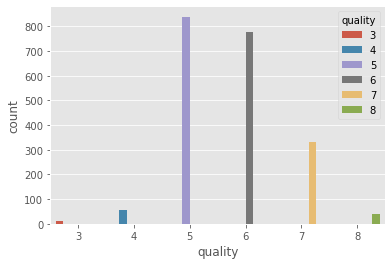

In [10]:
sns.countplot(x = 'quality', hue = 'quality', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that the data is imbalanced. Most of the data is related to quality lables 5, 6, and 7.</div>

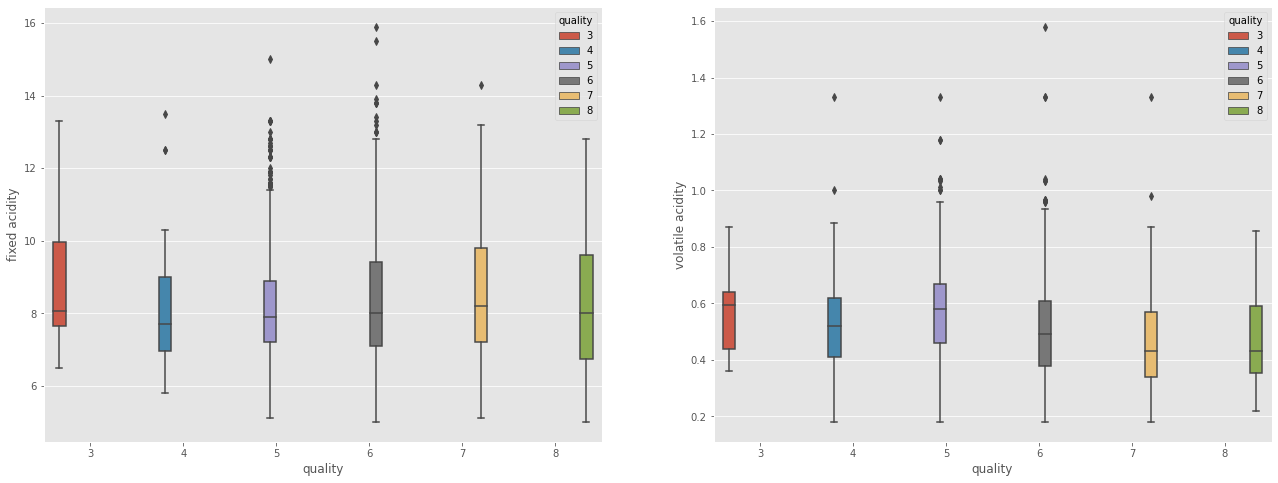

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'fixed acidity', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'volatile acidity', hue = 'quality', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the left panel, it seems that there is a very small increase in the fixed acidity medians (going from quality 4 to quality 7). On the right panel, there is decrease in the volatile acidity medians (going from quality 5 to quality 8).
</div>

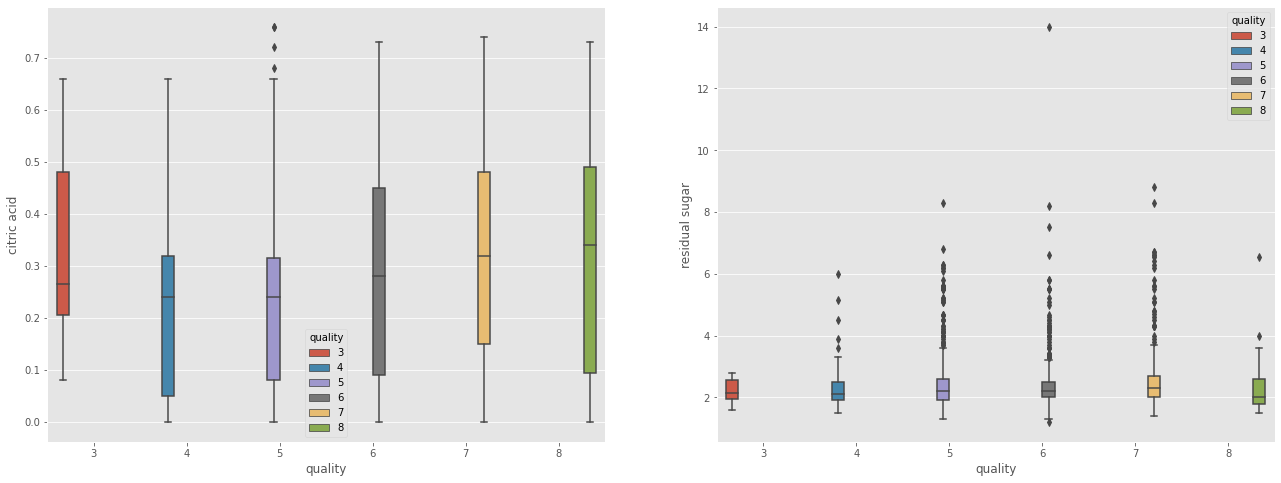

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'citric acid', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'residual sugar', hue = 'quality', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the left panel, it seems that there is an increase in the citric acid medians (going from quality 4 to quality 8). On the right panel, there is no an abovious pattern when compare the residual sugar distribuition of the different wine qualities.</div>

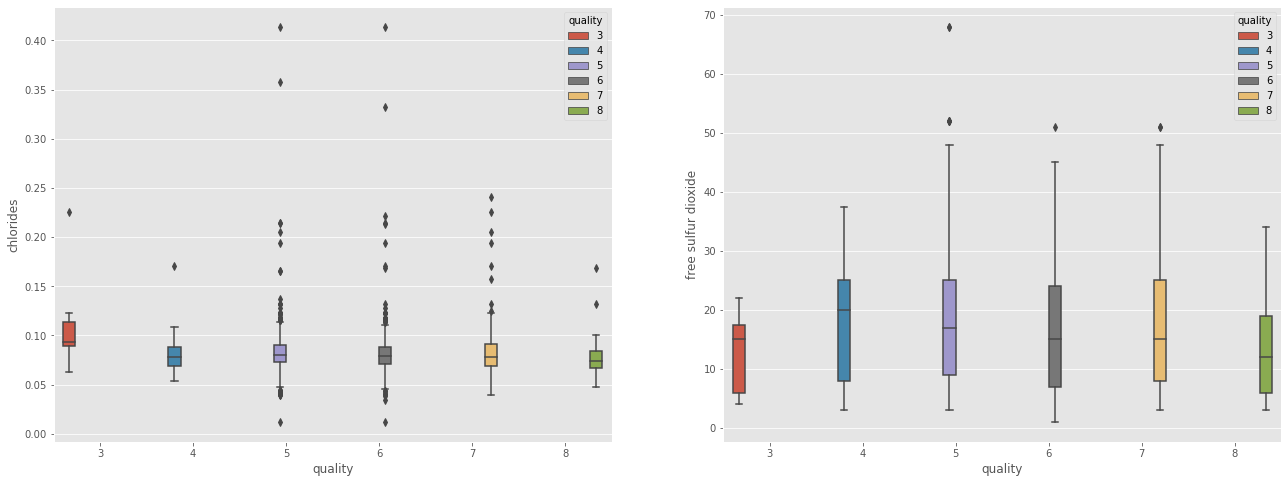

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'chlorides', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'free sulfur dioxide', hue = 'quality', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the left panel, there is no an abovious pattern when compare the residual sugar distribuitions of the different wine qualities. On the right panel, there is a decrease in the free sulfur dioxide emdian (going from quality 4 to quality 8).</div>

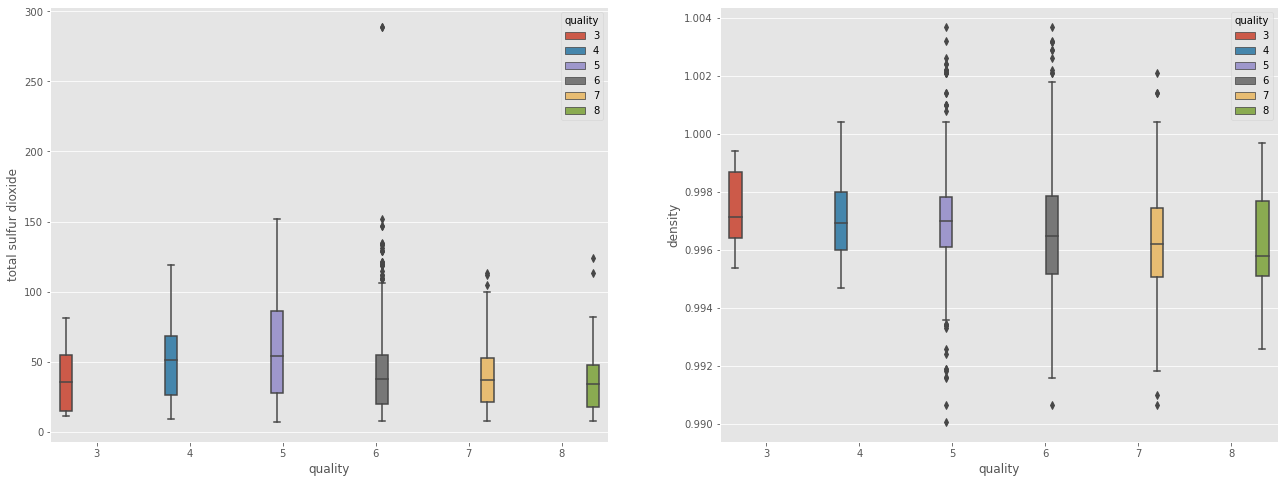

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'total sulfur dioxide', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'density', hue = 'quality', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the left panel, there is an increase in the total sulfur dioxide medians (going from quality 3 to quality 5), then there is a decrease in the total sulfur dioxide medians (going from quality 5 to quality 8). On the right panel, there is a decrease in the density medians (going from quality 3 to quality 8).
</div>

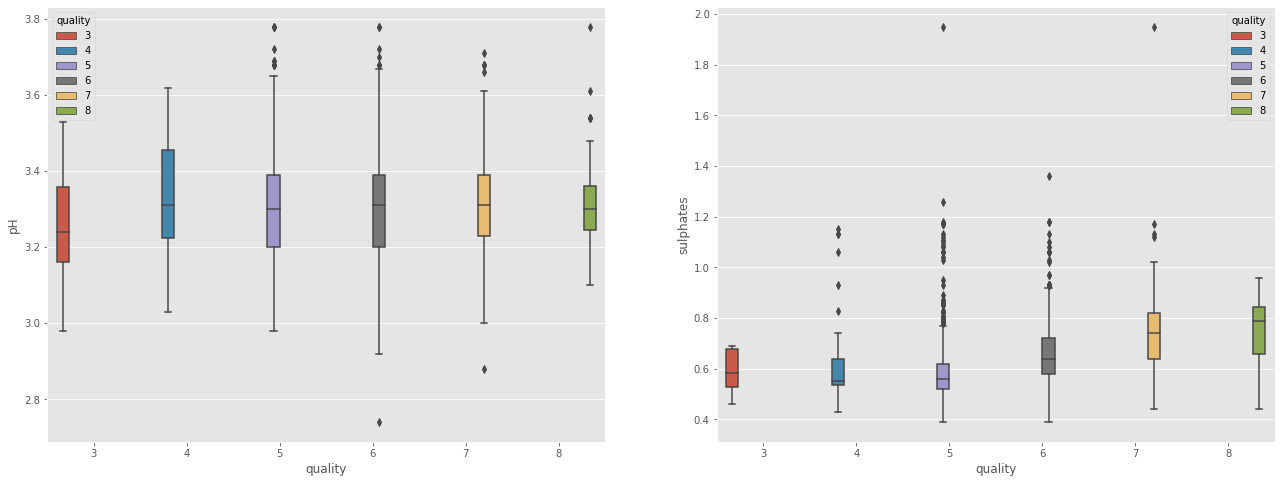

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'pH', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'sulphates', hue = 'quality', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the left panel, there is no an abovious pattern when compare the pH distribuitions of the different wine qualities. On the right panel, there is an increase in the sulphates medians (going from quality 5 to quality 8).
</div>

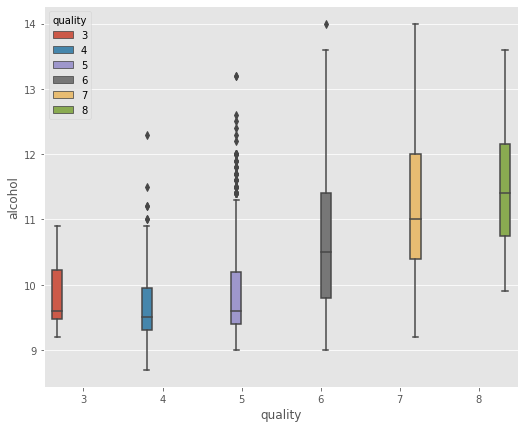

In [16]:
plt.figure(figsize = (8.5, 7))
sns.boxplot(x = 'quality', y = 'alcohol', hue = 'quality', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> In the above chart, there is an abovious increase in the alcohol medians (going from quality 4 to quality 8).
</div>

We next proceed to explore potential correlation among the predictor features in the train and test dataset.

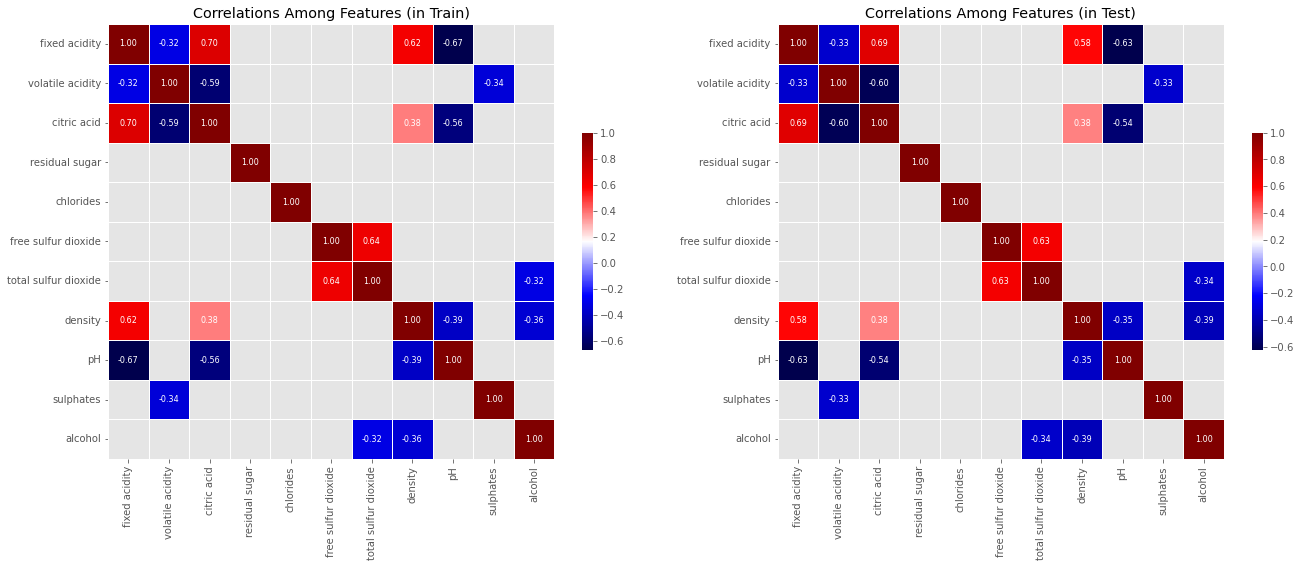

In [17]:
## Explore the correlation between all numerical features
corr_mat_train = train.drop(columns = ['Id', 'quality'], axis = 1).corr()
corr_mat_test = test.drop(columns = ['Id'], axis = 1).corr()

## Keep only correlation higher than a threshold
threshold = 0.3
corr_threshold_train = corr_mat_train[(corr_mat_train > threshold) | (corr_mat_train < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]

fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(corr_threshold_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

> <div class="alert alert-block alert-info">
<b>💡</b> From the above heatmaps, we see that the correlation among the features are the same in the train and test datasets.
</div>

We next proceed to compare the distribution of the features in the train and test datasets.

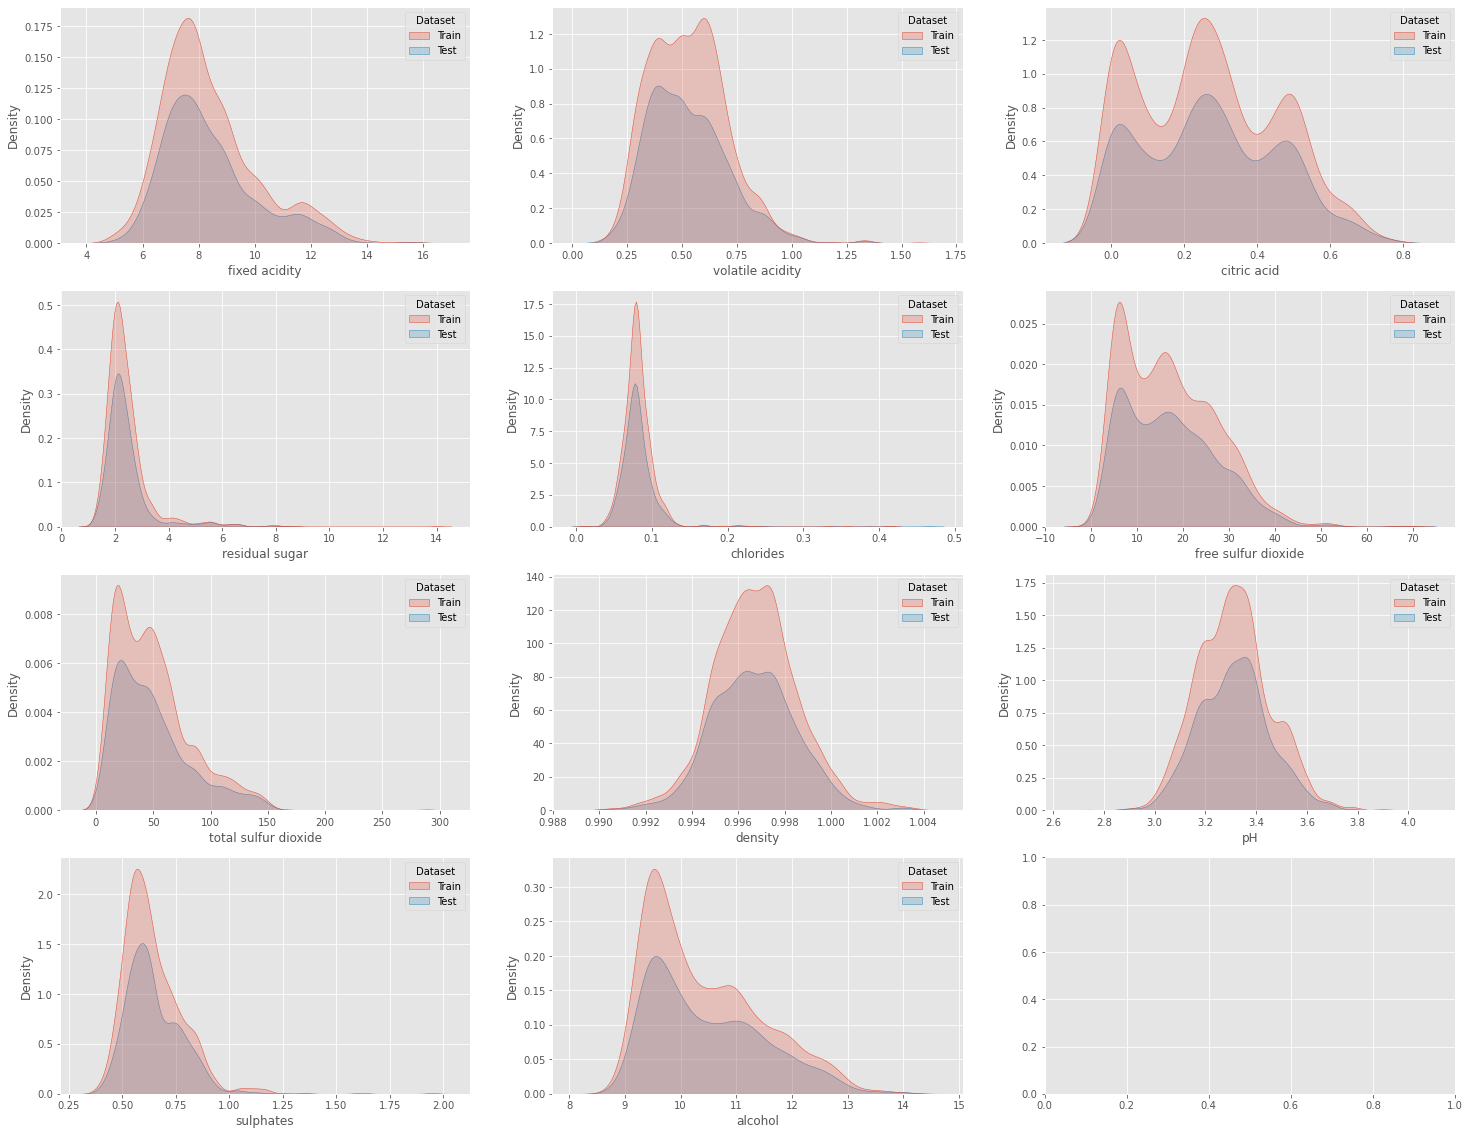

In [18]:
train_vis = train.drop(columns = 'quality', axis = 1).reset_index(drop = True).copy()
test_vis = test.copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(4, 3, figsize = (25, 20))

sns.kdeplot(ax = axes[0, 0], x = 'fixed acidity', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'volatile acidity', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'citric acid', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'residual sugar', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'chlorides', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'free sulfur dioxide', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 0], x = 'total sulfur dioxide', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 1], x = 'density', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 2], x = 'pH', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[3, 0], x = 'sulphates', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[3, 1], x = 'alcohol', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above density plots, we see that the distributions of the features are very similar in the train and test datasets.
</div>

<div class="alert alert-block alert-info">
<b>💡 Insights from EDA:</b><br> 
<ul>
    <li> Imbalanced dataset (not many 3, 4, and 8 quality labels). </li>
    <li> There is an increase in the citric acid medians (going from quality 4 to quality 8). </li>
    <li> There is a decrease in the free sulfur dioxide emdian (going from quality 4 to quality 8). </li>
    <li> There is a decrease in the density medians (going from quality 3 to quality 8). </li>
    <li> There is an increase in the sulphates medians (going from quality 5 to quality 8). </li>
    <li> There is an abovious increase in the alcohol medians (going from quality 4 to quality 8).</li>
    <li> The distributions of the features are very similar in the train and test datasets.</li>
    <li> There is a moderate positive correlation between fixed acidity and citric acid.</li>
    <li> There is a moderate negative correlation between fixed acidity and pH</li>
</ul>
</div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">OneVsRest Overview</h1> 

In this section, we briefly describe the one-vs-rest (one-vs-all) stratefy for multi-class classification. In this approach, one classifier is fitted against one class. For each of the classifiers, the class is then fitted against all the other classes, producing a real-valued decision confidence score, instead of class labels. From the confidence score, the maximum value is picked up to get the final class label. The advantage of one-vs-all is its interpretability and efficiency.

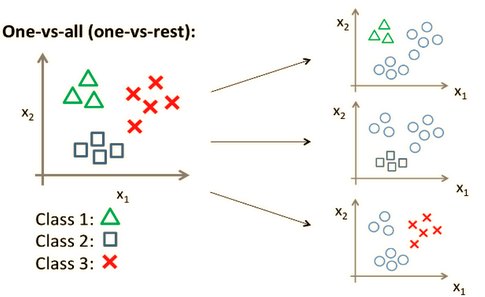

Notice that this approach can be implemented with any of the standard classifiers such as logistic regression, XGBoost, etc. In the next section, we build a base-line model using the one-vs-rest strategy combined with XGBoost.

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">OneVsRest: XGBoost</h1> 

In [19]:
test_md = test.copy()

X = train.drop(columns = ['Id', 'quality'], axis = 1)
Y = train['quality']
test_md = test_md.drop(columns = 'Id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'gpu_hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 5, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7)
        
        One_vs_Rest_XGB = OneVsRestClassifier(estimator = XGB_md).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        XGB_pred_1 = One_vs_Rest_XGB.predict(X_test)
        XGB_pred_2 = One_vs_Rest_XGB.predict(test_md)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average oof quadratic weighted kapp score over 5-folds (run 5 times) is:', XGB_cv_score)

The average oof quadratic weighted kapp score over 5-folds (run 5 times) is: 0.49699966910839033


In [20]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ]

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,5


In [21]:
submission.to_csv('XGB_baseline_onevsrest.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">XGBoost</h1> 

In this section, we model the data with XGBoost (wihtout using the OneVsRest strategy).

In [22]:
test_md = test.copy()

X = train.drop(columns = ['Id', 'quality'], axis = 1)
Y = train['quality'] - 3
test_md = test_md.drop(columns = 'Id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'gpu_hist',
                               colsample_bytree = 0.75, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 5, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_md)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.4980167454023123


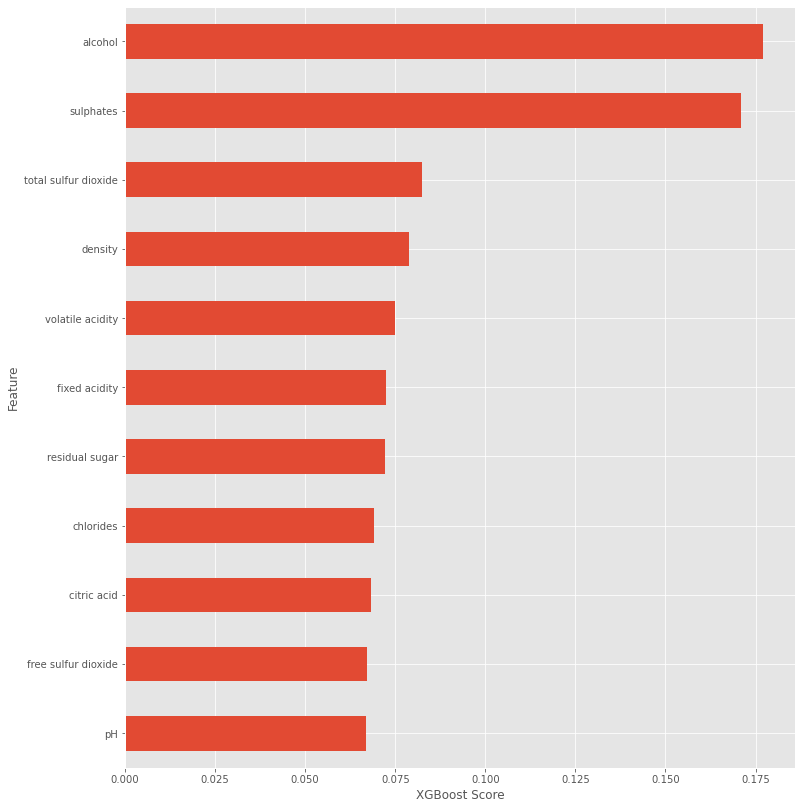

In [23]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

From the above chart, we see that, based on the XGBoost importance score, alcohol and sulphates are the top two most import features to predict wine quality.

In [24]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ] + 3

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,5


In [25]:
submission.to_csv('XGB_baseline_raw.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Feature Engineering</h1> 

In this section, I implemented a couple of features suggest in this [post](https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382698).

In [26]:
train['alcohol_density'] = train['alcohol']  * train['density']
train['sulphate/density'] = train['sulphates']  / train['density']

test['alcohol_density'] = test['alcohol']  * test['density']
test['sulphate/density'] = test['sulphates']  / test['density']

test_md = test.copy()

X = train.drop(columns = ['Id', 'quality'], axis = 1)
Y = train['quality'] - 3
test_md = test_md.drop(columns = 'Id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.75, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 5, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_md)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.5022545527932221


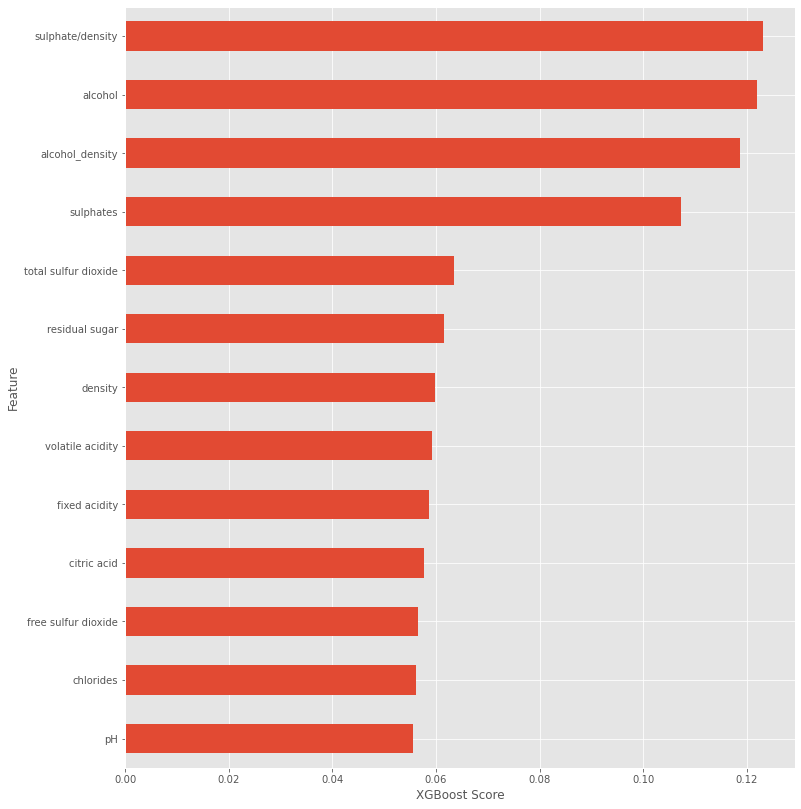

In [27]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

From the above chart, we see that the both the engineered featues are ranked among the top three most important features in the XGBoost model.

In [28]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ] + 3

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,5


In [29]:
submission.to_csv('XGB_baseline_raw_FE.csv', index = False)

Next, we proceed to build a XGBoost model only using the top four features from the previous model result. My hunch is that we may be able to reach the same model performance with less number of input features. 

In [30]:
test_md = test.copy()

X = train[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']]
Y = train['quality'] - 3

test_md = test_md[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']]

XGB_cv_scores = list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.75, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 5, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_md)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.5317666190241566


From the above, we see that only using four features, the CV-score increased significantly.

In [31]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ] + 3

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,6
3,2059,6
4,2060,6


In [32]:
submission.to_csv('XGB_FE_top_4.csv', index = False)

After tuning the hyper-parameter with the optuna framework, we re-run the XGBoost model.

In [33]:
XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.7, 
                               gamma = 5.5, 
                               learning_rate = 0.031, 
                               max_depth = 5, 
                               min_child_weight = 68, 
                               n_estimators = 8800, 
                               subsample = 0.41, 
                               random_state = 42).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_md)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.5280753543267158


In [34]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ] + 3

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,5
3,2059,6
4,2060,6


In [35]:
submission.to_csv('XGB_FE_top_4_tuned.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Model Comparison</h1>

| Model | Features | CV | LB |
| --- | --- | --- | --- |
| OneVsRest with XGBoost | all raw features | 0.49699 | 0.51894 |
| XGBoost | all raw featueres + sulphate/density | 0.49801 | 0.53390 |
| XGBoost | all raw featueres + sulphate/density + alcohol_density | 0.50225 | 0.54121 |
| XGBoost | sulphate/density + alcohol_density + alcohol + sulphates | 0.53176 | 0.54429 |
| XGBoost (tuned) | sulphate/density + alcohol_density + alcohol + sulphates | 0.52807 | 0.57265 |

# More work coming soon...
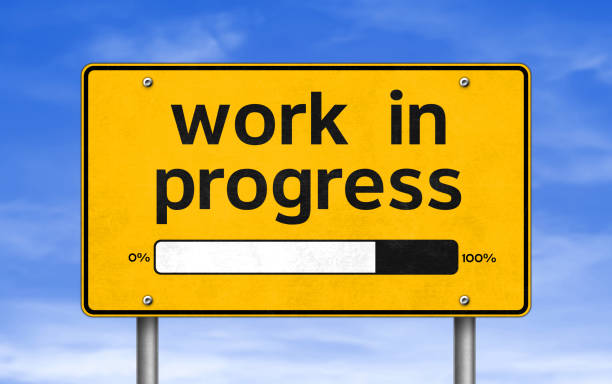